# Variational Autoencoder (VAE) with Keras

Modified from code source: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#full-vae-code

## Model imports

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy, KLD
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

# Following section allow using RTX graphic cards
gpu_devices = tf.config.experimental.list_physical_devices('GPU') 
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

## Loading data

In [2]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

## Model configuration

In [3]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

## Data preprocessing

In [4]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats (which presumably speeds up the training process)
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Define padding required to get a multiple of 8 as dimensions 
# (for performances on tensor cores)
input_padding = (0, 0, 0, 0)
v_pad = img_height % 8
h_pad = img_width % 8

if v_pad != 0 or h_pad != 0:
    top_pad = v_pad // 2
    left_pad = h_pad // 2
    input_padding = ((top_pad, v_pad - top_pad), (left_pad, h_pad - left_pad))

## Creating the encoder

### Encoder definition

In [5]:
# Definition
i = Input(shape=input_shape, name='encoder_input')
cx = ZeroPadding2D(padding=input_padding)(i)
cx = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx = BatchNormalization()(cx)
x = Flatten()(cx)
x = Dense(20, activation='relu', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

### Reparameterization trick

In [6]:
# Define sampling with reparameterization trick
@tf.function
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

### Encoder instantiation

In [7]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()
#keras.utils.plot_model(encoder, 'broken_deep_model.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 8)    80          zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 8)    32          conv2d[0][0]                     
____________________________________________________________________________________________

## Creating the decoder

### Decoder definition

In [8]:
# Definition
d_i = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu', kernel_initializer = 'he_normal')(d_i)
x = BatchNormalization()(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same')(cx)
o = Cropping2D(input_padding, name='decoder_output')(cx)

### Decoder instantiation

In [9]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3072      
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 8)         1160

## Creating the whole VAE

In [10]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 22008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         10817     
Total params: 32,825
Trainable params: 30,641
Non-trainable params: 2,184
_________________________________________________________________


## Defining custom VAE loss function

In [11]:
# Define loss
@tf.function
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)
    

## Compilation & training

In [12]:
# Compile with tf optimiser to use tensor cores
opt = tf.keras.optimizers.Adam()
opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
vae.compile(optimizer=opt, loss=kl_reconstruction_loss, experimental_run_tf_function=False)

In [13]:
# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 99us/sample - loss: 249.7104 - val_loss: 190.6256
Epoch 2/100
48000/48000 [==============================] - 3s 67us/sample - loss: 183.3644 - val_loss: 177.1816
Epoch 3/100
48000/48000 [==============================] - 4s 74us/sample - loss: 174.6167 - val_loss: 171.5517
Epoch 4/100
48000/48000 [==============================] - 3s 69us/sample - loss: 170.0914 - val_loss: 167.7410
Epoch 5/100
48000/48000 [==============================] - 3s 71us/sample - loss: 166.8124 - val_loss: 165.3941
Epoch 6/100
48000/48000 [==============================] - 4s 77us/sample - loss: 164.3538 - val_loss: 163.3325
Epoch 7/100
48000/48000 [==============================] - 3s 71us/sample - loss: 162.5002 - val_loss: 161.5089
Epoch 8/100
48000/48000 [==============================] - 4s 75us/sample - loss: 161.0817 - val_loss: 160.2770
Epoch 9/100
48000/48000 [=============================

## Visualizing VAE results

##### Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
##### (François Chollet).

### Visualizing inputs mapped onto latent space

In [15]:
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(12.3, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

### Visualizing samples from the latent space

In [16]:
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                      j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.show()

### Calling the visualizers

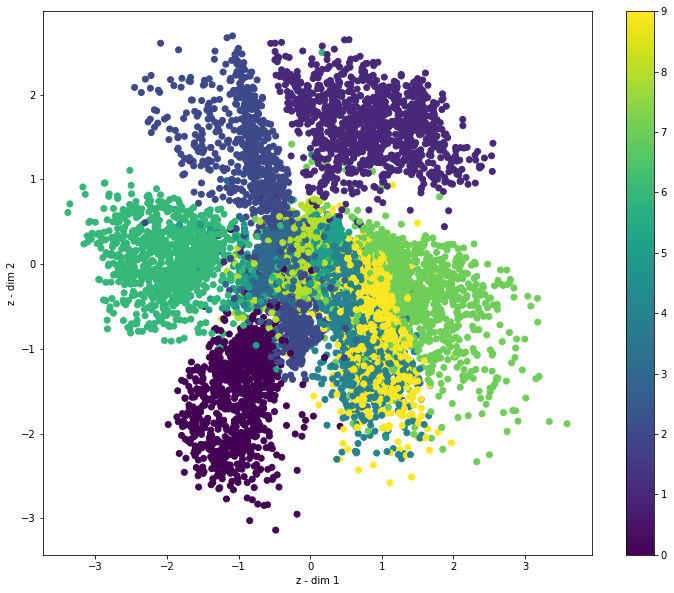

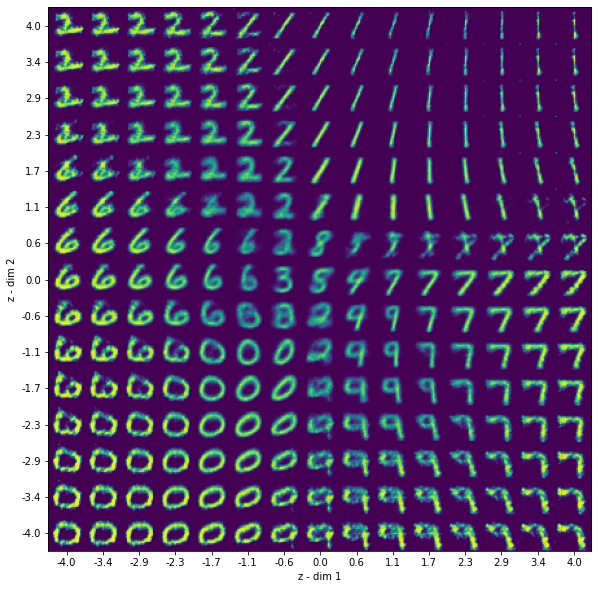

In [17]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

## Compare examples with reconstructed image

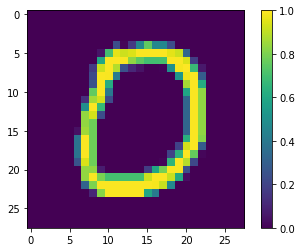

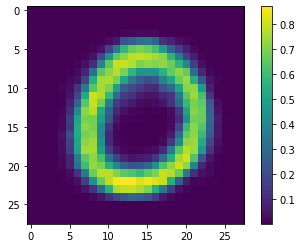

In [48]:
import numpy as np
from matplotlib import pyplot as plt

images = np.zeros((2, img_width, img_height, num_channels))
inputNumber = input_test[10] # <----- Change index here to test another example

# Create input image
imgInput = np.squeeze(inputNumber, axis=2)

# Create output image
data = decoder.predict(encoder.predict(inputNumber.reshape(1, 28, 28, 1)))
data = data[0]
data = np.squeeze(data, axis=2)

# Display images
images = (imgInput, data)
for im in images:
    plt.figure()
    plt.imshow(im)
    plt.colorbar()

## Save & load models

### Simple VAE model

In [17]:
# Save VAE weights
vae.save_weights('models/vae/vae')

In [13]:
# Load VAE weights
vae.load_weights('models/vae/vae')

## DCGAN-like architecture

In [5]:
no_epochs = 5

# Encoder definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = ZeroPadding2D(padding=input_padding)(i)
cx      = Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu', kernel_initializer = 'he_normal')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Decoder definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu', kernel_initializer = 'he_normal')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same')(cx)
o     = Cropping2D(input_padding, name='decoder_output')(cx)

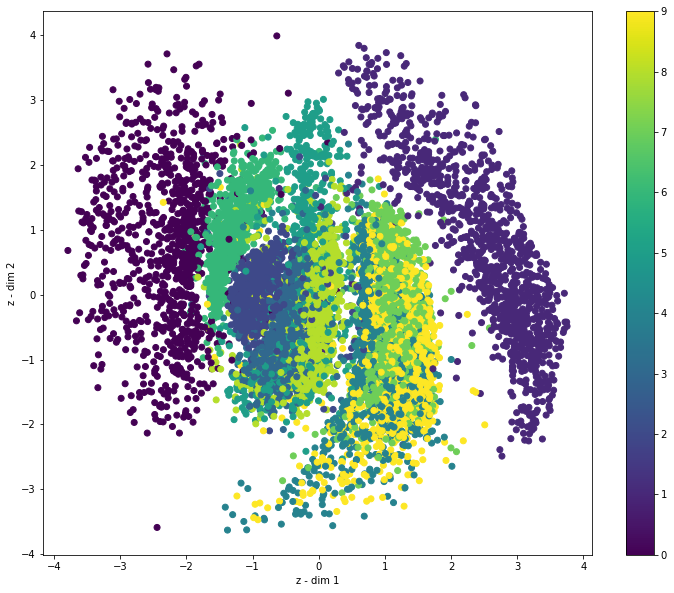

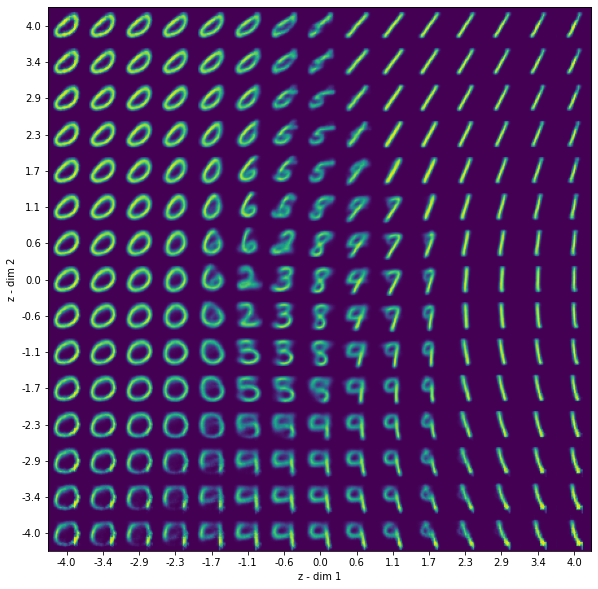

In [14]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

In [ ]:
# Save DCGAN-like architecture models
vae.save_weights('models/dcgan-like/vae')

In [ ]:
# Load DCGAN-like architecture models
vae.load_weights('models/dcgan-like/vae')